In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from matplotlib import pylab as plt


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


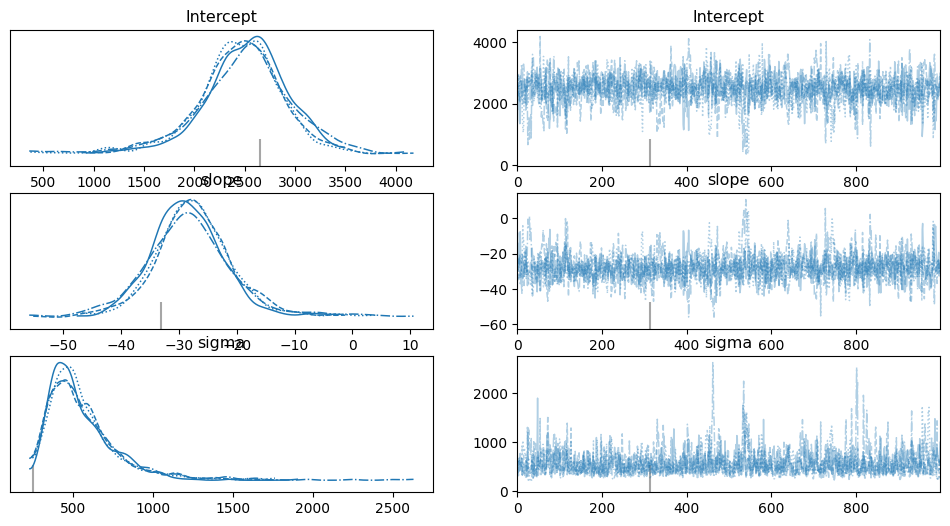

In [2]:

df = pd.DataFrame({'price':[100,90,70,60,40,20,10],'demand':[100,120,200,300,1200,2000,2800]}).astype(float)


def price_demand_info(df):
    return df['price'], df['demand'], df['price'].min(), df['price'].max(), df['demand'].min(), df['demand'].max()

def simulator_distribution(price, demand, sample_num, summary=True):
    with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        sigma = pm.HalfCauchy("sigma", beta=1000)
        intercept = pm.Normal("Intercept", 0, sigma=2000)
        slope = pm.Normal("slope", 0, sigma=2000)
        # Define likelihood
        likelihood = pm.Normal("y", mu=intercept + slope * price, sigma=sigma, observed=demand)

        # Inference!
        # draw sample_num posterior samples using NUTS sampling
        s = pm.sample(sample_num)

        if summary:
            pm.summary(s)
            pm.plot_trace(s)

    return s
price, demand, price_min, price_max, demand_min, demand_max = price_demand_info(df)
samples = simulator_distribution(price, demand, 1000)

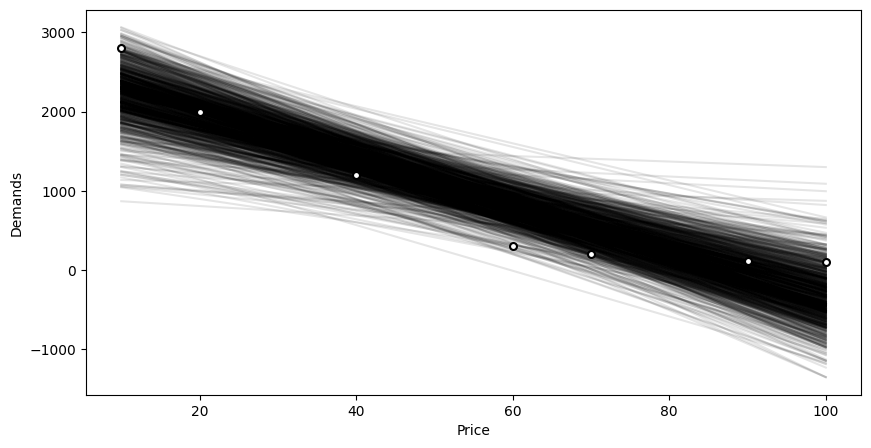

In [4]:
def posterior_predict(samples):
    p = np.linspace(price_min, price_max)
    demand_price = samples.posterior["Intercept"][0].data + samples.posterior["slope"][0].data * np.array(p).reshape(-1,1)
    # demand_price = np.exp(s.posterior['log_b'][0].data - s.posterior['c'][0].data* np.log(p).reshape(-1, 1))
    fig = plt.figure(figsize=(10, 5))
    plt.plot(p, demand_price, c = 'k', alpha = 0.1)
    plt.plot(price, demand, 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=5)
    plt.xlabel('Price')
    plt.ylabel('Demands')
    plt.show()
    return demand_price
demand_prices_posterior = posterior_predict(samples)



In [27]:
# Question 1-1: find out the optimal price that maximises revenue.
#  Hint: our two different methods place the answer between 25 and 50. We are more interested
# in your approach, methods and code than getting an exact answer for this part.


price_max_revenue 44.89795918367347


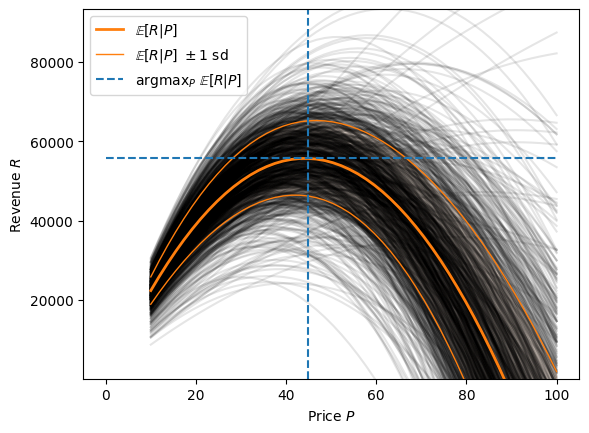

In [5]:
# finding optimal price by computing expectation of revenues(first method)

def revenue_maximizing_price(demand_prices, sd):
    p = np.linspace(price_min, price_max)
    R = np.multiply((p.reshape(-1,1)),demand_prices)
    plt.plot(p,R,c='k',alpha=0.1);
    plt.plot(p,np.mean(R,1).T,c='C1',lw=2,label="$\mathbb{E}[R|P]$");
    plt.fill_between(p,(np.mean(R,1)-np.std(R,sd)).T,(np.mean(R,1)+np.std(R,sd)).T,alpha=0.1,color='C1')
    plt.plot(p,(np.mean(R,1)+np.std(R,sd)).T,c='C1',lw=1,label="$\mathbb{E}[R|P]\ \pm$1 sd");
    plt.plot(p,(np.mean(R,1)-np.std(R,sd)).T,c='C1',lw=1);
    pmax = p[np.argmax(np.mean(R,1))]
    revenue_max = np.max(np.mean(R,1))
    plt.vlines(pmax, demand_min, (demand_max*price_max)/3,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[R|P]$")
    plt.hlines(revenue_max, 0,price_max,colors='C0',linestyles='dashed')

    plt.ylim(demand_min,(demand_max* price_max)/3);
    plt.xlabel("Price $P$")
    plt.ylabel("Revenue $R$")

    plt.legend();
    # print('price_max', pmax)
    return pmax

print('price_max_revenue', revenue_maximizing_price(demand_prices_posterior, sd=1))


In [9]:
# finding optimal price by using Linear Programming (second method)

def optimal_price_probabilities(prices, demands, constraint):   
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([constraint]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob, revenues


p = np.linspace(price_min, price_max)
out, rev = optimal_price_probabilities(p, demand_prices_posterior.T[0], price_max * demand_max)
print('price_max_revenue', p[out.argmax()])


price_max_revenue 50.40816326530612


In [29]:
# Question 1-2: Knowing the demand (from the previous question) and the supplier price, and assuming
# that the only costs we have are the cost of the goods we sell, please find the price that
# maximizes our profits.


price_max_profit 46.734693877551024


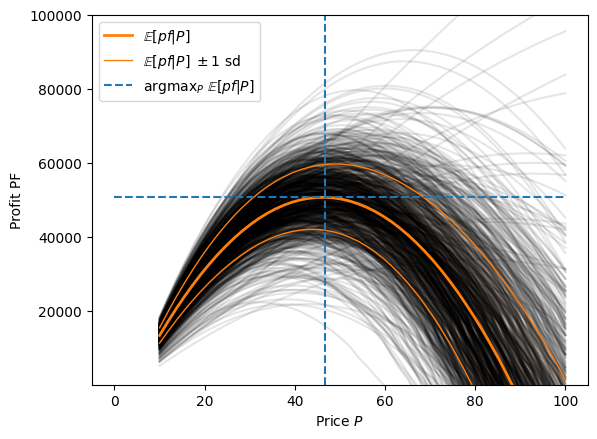

In [10]:
def profit_formula():
    demand_prices = samples.posterior["Intercept"][0].data + samples.posterior["slope"][0].data * np.array(p).reshape(-1,1)[:,:500]

    discount = demand_prices.copy()
    discount[discount<=50] = 1
    discount[(50<discount) & (discount<=100)] = 12
    discount[(100<discount) & (discount<=200)] = 8
    discount[200<discount] = 4

    p_sum = p.reshape(-1,1) - discount
    proft_price = np.multiply(p_sum, demand_prices)
    return proft_price

def profit_maximizing_price(demand_prices, sd):
    PF = profit_formula()
    plt.plot(p,PF,c='k',alpha=0.1);
    plt.plot(p,np.mean(PF,1).T,c='C1',lw=2,label="$\mathbb{E}[pf|P]$");
    plt.fill_between(p,(np.mean(PF,1)-np.std(PF,1)).T,(np.mean(PF,1)+np.std(PF,1)).T,alpha=0.1,color='C1')
    plt.plot(p,(np.mean(PF,1)+np.std(PF,1)).T,c='C1',lw=1,label="$\mathbb{E}[pf|P]\ \pm$1 sd");
    plt.plot(p,(np.mean(PF,1)-np.std(PF,1)).T,c='C1',lw=1);
    pmax = p[np.argmax(np.mean(PF,1))]
    profit_max = np.max(np.mean(PF,1))
    plt.vlines(pmax,100,100000,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[pf|P]$")
    plt.hlines(profit_max, 0,100,colors='C0',linestyles='dashed')

    plt.ylim(100,100000);
    plt.xlabel("Price $P$")
    plt.ylabel("Profit PF")

    plt.legend();
    # print('price_max', pmax)
    return pmax

print('price_max_profit', profit_maximizing_price(demand_prices_posterior, sd=1))
